In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys                                                                                                                                                  
import tensorflow as tf                                                                 
from tensorflow.keras.models import Sequential                            
from tensorflow.keras.layers import Dense, LSTM , Dropout, BatchNormalization                                     
from tensorflow.keras.optimizers import Adam                                            
from tensorflow.keras.callbacks import EarlyStopping                                   
from sklearn.preprocessing import MinMaxScaler                                          
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error  
from math import sqrt
from keras import optimizers
import datetime as dt
from datetime import date,datetime
import time
plt.style.use('ggplot')                                                                 

In [27]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # đảm bảo kết quả tái lập
    torch.backends.cudnn.benchmark = False     # tắt auto-tuning để đảm bảo tái lập




In [28]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=80,  verbose=1, mode='min')  
callbacks_list = [earlystop]                                                                          

In [29]:
data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [30]:
def fit_model_LSTM(train, val, timesteps, hl, lr, batch, epochs):
    # np.random.seed(1)
    # tf.random.set_seed(2)

    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu cho tập train
    for i in range(timesteps, train.shape[0]):  
        X_train.append(train[i-timesteps:i])  
        Y_train.append(train[i][0])  
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu cho tập validation
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xác định số đặc trưng
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"Input shape: {input_shape}, X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}, X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
    # Xây dựng model
    model = Sequential()
    model.add(LSTM(hl[0], input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.2))
    for i in range(1, len(hl)-1):  
        model.add(LSTM(hl[i], activation='relu', return_sequences=True))  
        # model.add(Dropout(0.2))
    model.add(LSTM(hl[-1], activation='relu', return_sequences=False))
    model.add(Dense(1))  

    # Biên dịch mô hình
    model.compile(optimizers.Adam(learning_rate=lr), loss='mean_squared_error')

    # Thêm callback để tránh overfitting
    callbacks_list = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, 
                        validation_data=(X_val, Y_val), verbose=1, shuffle=False,
                        callbacks=callbacks_list)

    return model, history.history['loss'], history.history['val_loss']

In [31]:
def evaluate_model(model, test, timesteps,sc):


    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)   
    Y_test_inv = np.exp(sc.inverse_transform(np.concatenate([Y_test.reshape(-1, 1), 
                                                  np.zeros((Y_test.shape[0], test.shape[1]-1))], axis=1))[:,0])
    Y_hat_inv = np.exp(sc.inverse_transform(np.concatenate([Y_hat.reshape(-1, 1), 
                                                 np.zeros((Y_hat.shape[0], test.shape[1]-1))], axis=1))[:,0])                  
    mse = mean_squared_error(Y_test_inv, Y_hat_inv)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test_inv, Y_hat_inv)
    mae = np.mean(np.abs(Y_test_inv - Y_hat_inv))
    r2 = r2_score(Y_test_inv, Y_hat_inv)
    return mse, rmse, mape,mae, r2, Y_test_inv, Y_hat_inv

In [32]:
# Plotting the predictions: vẽ y_test và y_hat -> trực quan hoá kqua
def plot_data_LSTM(Y_test, Y_hat):
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, c = 'r')                                 #test màu đỏ
    plt.plot(Y_hat, c = 'y')                                  #dự đoán màu vàng
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using LSTM")
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()  

In [33]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(14, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

In [34]:
# Ngày bắt đầu và tổng số ngày
start_date = dt.date(2020, 3, 8)
end_date = dt.date(2025, 5, 5)
total_days = (end_date - start_date).days + 1  # Đếm cả ngày cuối cùng


train_days = int(total_days * 0.7)
val_days = int(total_days * 0.15)
test_days = total_days - train_days - val_days  # Phần còn lại cho test

# Xác định ngày kết thúc cho từng tập
train_end = start_date + dt.timedelta(days=train_days - 1)
val_end = train_end + dt.timedelta(days=val_days)



LSTM+SA

In [35]:
timesteps_1 = 15
hl_1 = [40, 30]  # Số lượng nơ-ron trong các lớp LSTM
lr_1 = 1e-3     
batch_size_1 =64
num_epochs_1 = 100

In [36]:
data['close'] = np.log(data[['close']])
series = data[['close','sentiment_sector','sentiment_direct_PLX']]

series.fillna(0, inplace=True)
# Lấy dữ liệu
train_data_1 = series.loc[start_date:train_end]
val_data_1 = series.loc[train_end + dt.timedelta(days=1):val_end]
test_data_1 = series.loc[val_end + dt.timedelta(days=1):]

In [37]:
train_data_1 

,close,sentiment_sector,sentiment_direct_PLX
Date,,,
2020-03-18,3.551053,0.292511,0.0
2020-03-19,3.502249,-0.239021,0.0
2020-03-20,3.514824,0.127502,0.0
2020-03-21,3.514824,-0.219907,0.0
2020-03-22,3.514824,-0.452034,0.0
...,...,...,...
2023-10-13,3.564449,0.000000,0.0
2023-10-14,3.564449,0.000000,0.0
2023-10-15,3.564449,0.000000,0.0


In [38]:


sc_1 = MinMaxScaler() #thu nhỏ về khoảng [0,1]
train_1 = sc_1.fit_transform(train_data_1)
val_1 = sc_1.transform(val_data_1)
test_1 = sc_1.transform(test_data_1)
print(train_1.shape, val_1.shape, test_1.shape)

(1309, 3) (282, 3) (284, 3)


Input shape: (15, 3), X_train shape: (1294, 15, 3), Y_train shape: (1294,), X_val shape: (267, 15, 3), Y_val shape: (267,)
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.3212 - val_loss: 0.0091
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - val_loss: 0.0041
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0134 - val_loss: 0.0031
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 9.7042e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 11/100

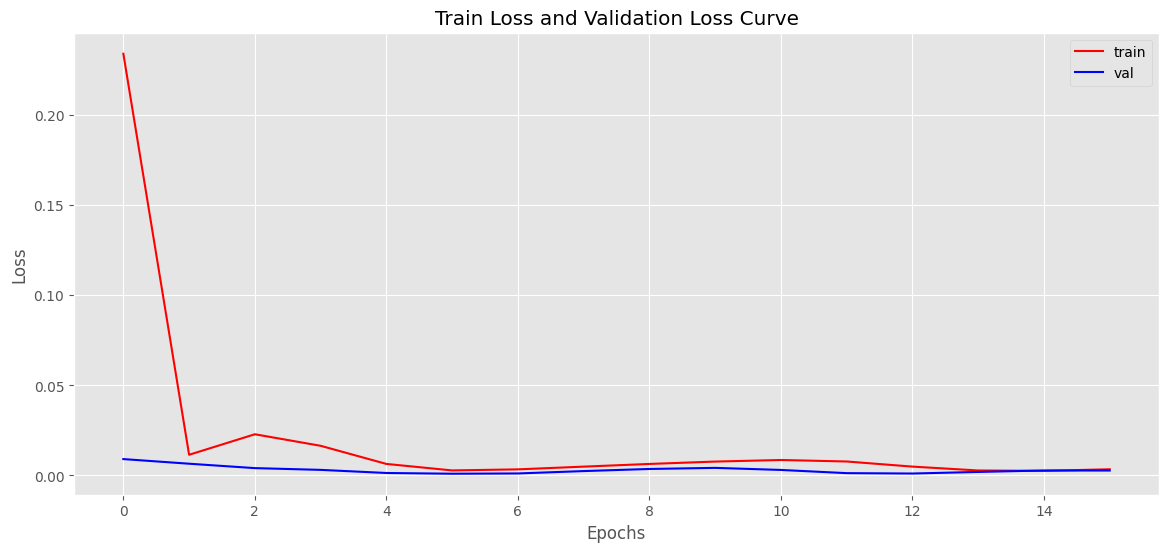

In [39]:
model_1, train_error_1, val_error_1 = fit_model_LSTM(train_1, val_1, timesteps_1, hl_1, lr_1, batch_size_1, num_epochs_1)
plot_error(train_error_1, val_error_1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MSE = 2.366812855124949
RMSE = 1.5384449470569135
MAPE = 0.02919780528321077
MAE = 1.1972879429567467
R-Squared Score = 0.8593827464157469


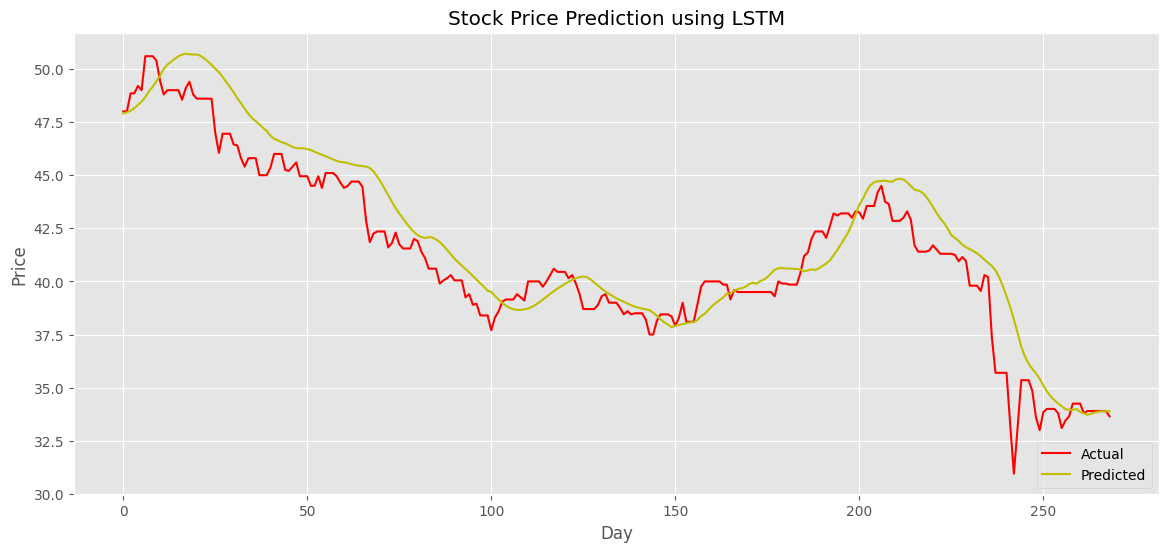

In [40]:
mse_1, rmse_1, mape_1,mae_1, r2_1, true_1, predicted_1 = evaluate_model(model_1, test_1, timesteps_1,sc_1) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse_1))
print('RMSE = {}'.format(rmse_1))
print('MAPE = {}'.format(mape_1))
print('MAE = {}'.format(mae_1))
print('R-Squared Score = {}'.format(r2_1))
plot_data_LSTM(true_1, predicted_1)


TIMESNET+SA

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
set_seed(42)
seq_len = 15
pred_len = 1
# Tải dữ liệu và tiền xử lý
data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data = data[['close', 'sentiment_sector', 'sentiment_direct_PLX']]
data['close'] = np.log(data['close'])
# data['volume'] = np.log(data['volume'] + 1)  
# data['sentiment_sector'] = data['sentiment_sector'].shift(1)
# data['sentiment_direct_PLX'] = data['sentiment_direct_PLX'].shift(1)
data.fillna(0, inplace=True) 
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data[['close', 'sentiment_sector', 'sentiment_direct_PLX']] = scaler.fit_transform(data[['close', 'sentiment_sector', 'sentiment_direct_PLX']])

# Chia dữ liệu thành train, val, test (80% train, 10% validation, 10% test)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size + val_size]
test = data.iloc[train_size + val_size:]

# Hàm tạo sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data.iloc[i:i+seq_len].values)  
        y.append(data.iloc[i+seq_len:i+seq_len+pred_len, 0])  
    return np.array(X), np.array(y)

# Tạo sequences cho các tập train, val, test
X_train, y_train = create_sequences(train, seq_len, pred_len)
X_val, y_val = create_sequences(val, seq_len, pred_len)
X_test, y_test = create_sequences(test, seq_len, pred_len)
# Convert dữ liệu sang tensor và thêm chiều cuối cho phù hợp với output model
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# In ra kích thước của các tập dữ liệu
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: torch.Size([1297, 15, 3]), torch.Size([1297, 1, 1])
Val: torch.Size([266, 15, 3]), torch.Size([266, 1, 1])
Test: torch.Size([267, 15, 3]), torch.Size([267, 1, 1])


In [42]:
# Mô hình TimesNet
import torch
import torch.nn as nn

class TimesBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, dilation_base, dropout):
        super(TimesBlock, self).__init__()
        padding = ((kernel_size - 1) * dilation_base) // 2
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.norm = nn.LayerNorm(in_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):  
        residual = x
        x = x.permute(0, 2, 1)  
        out = self.conv1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.permute(0, 2, 1)  
        out = self.norm(out + residual)
        return out


class TimesNet(nn.Module):
    def __init__(self, config):
        super(TimesNet, self).__init__()

        self.input_dim = config["input_dim"]               
        self.hidden_dim = config["hidden_dim"]             
        self.pred_len = config["pred_len"]                 
        self.output_dim = config["output_dim"]             
        self.n_blocks = config["n_blocks"]                 
        self.kernel_size = config["kernel_size"]           
        self.dropout = config.get("dropout", 0.2)          

        self.input_proj = nn.Linear(self.input_dim, self.hidden_dim)
        self.blocks = nn.ModuleList([
            TimesBlock(self.hidden_dim, self.kernel_size, dilation_base=2**i, dropout=self.dropout)
            for i in range(self.n_blocks)
        ])
        self.output_proj = nn.Linear(self.hidden_dim, self.pred_len * self.output_dim)

    def forward(self, x):  
        x = self.input_proj(x)  
        for block in self.blocks:
            x = block(x)
        out = self.output_proj(x[:, -1, :])  
        out = out.view(-1, self.pred_len, self.output_dim)
        return out


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "input_dim": X_train.shape[2],
    "hidden_dim": 32,
    "pred_len": pred_len,
    "output_dim": 1,
    "n_blocks": 2,
    "kernel_size": 3,
    "dropout": 0.2,
}

model = TimesNet(config).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001, weight_decay=1e-3)
# Huấn luyện mô hình
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []

    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = loss_fn(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.show()
    return train_losses, val_losses


Epoch 1/100 - Train Loss: 0.0646 - Val Loss: 0.0849
Epoch 2/100 - Train Loss: 0.0597 - Val Loss: 0.0656
Epoch 3/100 - Train Loss: 0.0484 - Val Loss: 0.0304
Epoch 4/100 - Train Loss: 0.0342 - Val Loss: 0.0118
Epoch 5/100 - Train Loss: 0.0328 - Val Loss: 0.0077
Epoch 6/100 - Train Loss: 0.0287 - Val Loss: 0.0070
Epoch 7/100 - Train Loss: 0.0208 - Val Loss: 0.0108
Epoch 8/100 - Train Loss: 0.0149 - Val Loss: 0.0160
Epoch 9/100 - Train Loss: 0.0150 - Val Loss: 0.0149
Epoch 10/100 - Train Loss: 0.0125 - Val Loss: 0.0075
Epoch 11/100 - Train Loss: 0.0094 - Val Loss: 0.0018
Epoch 12/100 - Train Loss: 0.0070 - Val Loss: 0.0016
Epoch 13/100 - Train Loss: 0.0088 - Val Loss: 0.0021
Epoch 14/100 - Train Loss: 0.0086 - Val Loss: 0.0015
Epoch 15/100 - Train Loss: 0.0070 - Val Loss: 0.0024
Epoch 16/100 - Train Loss: 0.0067 - Val Loss: 0.0035
Epoch 17/100 - Train Loss: 0.0081 - Val Loss: 0.0028
Epoch 18/100 - Train Loss: 0.0074 - Val Loss: 0.0022
Epoch 19/100 - Train Loss: 0.0061 - Val Loss: 0.0034
Ep

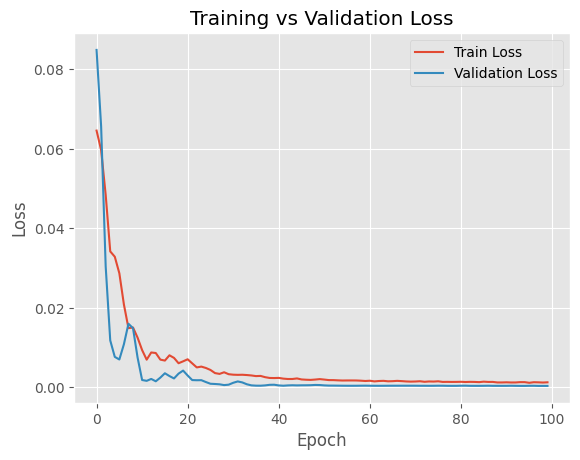

In [44]:
train_losses, val_losses = train_model(
    model, X_train, y_train, X_val, y_val, loss_fn, optimizer,epochs=100
)


In [45]:
def evaluate(preds, actuals):

    pred_flat = preds.flatten()
    actual_flat = actuals.flatten()

    rmse = mean_squared_error(actual_flat, pred_flat, squared=False)
    mae = mean_absolute_error(actual_flat, pred_flat)
    mape = mean_absolute_percentage_error(actual_flat, pred_flat)
    r2 = r2_score(actual_flat, pred_flat)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")
    
model.eval()
with torch.no_grad():
    # Giả sử model output và y_test chỉ là cột 'close'
    preds = model(X_test.to(device)).cpu().numpy()
    actuals = y_test.cpu().numpy()

    # Reshape về (n_samples, 1)
    preds = preds.reshape(-1, 1)
    actuals = actuals.reshape(-1, 1)

    # # Vị trí cột 'close' trong scaler
    close_idx = ['close', 'sentiment_score', 'sentiment_score_PLX'].index('close')
    
    # Tạo dummy array với 3 cột để đảo chuẩn hóa
    dummy_preds = np.zeros((preds.shape[0], 3))
    dummy_preds[:, close_idx] = preds.flatten()

    dummy_actuals = np.zeros((actuals.shape[0], 3))
    dummy_actuals[:, close_idx] = actuals.flatten()

    # Đảo chuẩn hóa
    preds_original = np.exp(scaler.inverse_transform(dummy_preds)[:, close_idx])
    actuals_original = np.exp(scaler.inverse_transform(dummy_actuals)[:, close_idx])
    

    # Đánh giá
    evaluate(preds_original, actuals_original)


RMSE: 0.7842
MAE : 0.5573
MAPE: 0.0135
R²  : 0.9630


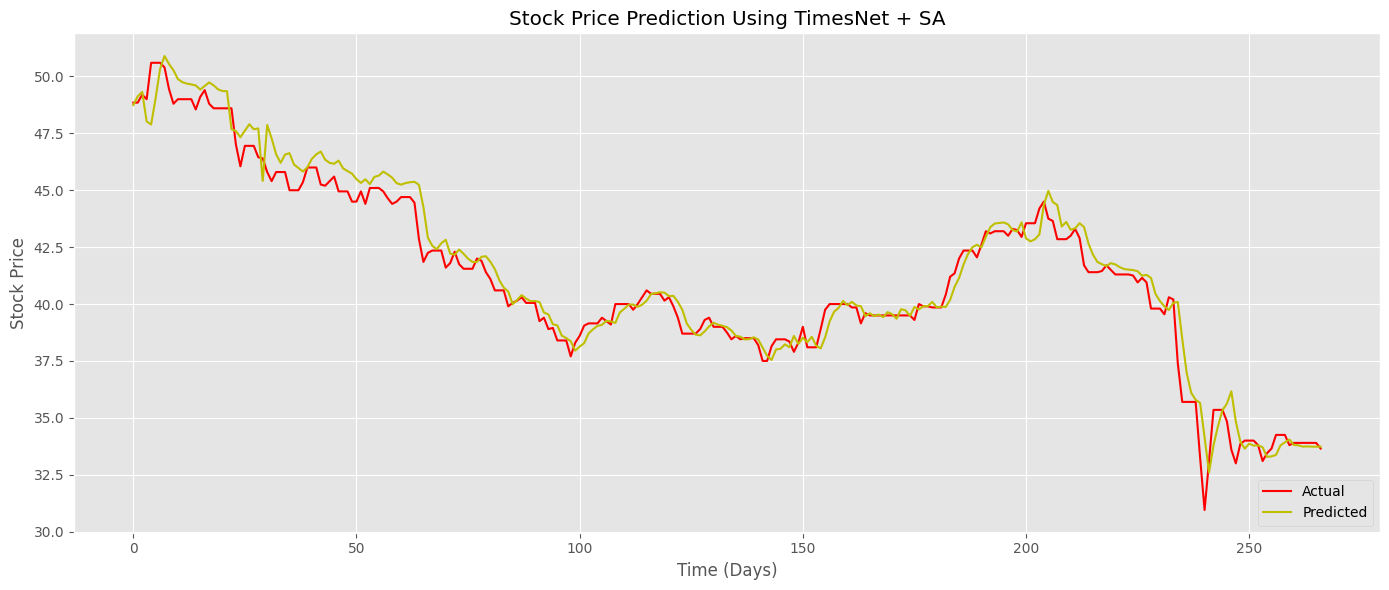

In [46]:
def plot_data(y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, c='r', label='Actual')        # Giá trị thực tế (giá close thật)
    plt.plot(y_pred, c='y', label='Predicted')     # Giá trị dự đoán (giá close dự đoán)
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.title("Stock Price Prediction Using TimesNet + SA")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_data(actuals_original, preds_original)

Mô hình ARIMA + SA

In [47]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [48]:
stock_data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
df_close = stock_data['close']

In [49]:
df_sentiment = stock_data[['sentiment_direct_PLX','sentiment_sector']].shift(1)
df_sentiment.fillna(0, inplace=True)
df_log = np.log(df_close)
n = int(len(df_log)*0.8)
train_y, test_y = df_log[:n], df_log[n:]
train_exog, test_exog = df_sentiment[:n], df_sentiment[n:]

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8039.359, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8037.666, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8037.291, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8036.350, Time=0.48 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8034.360, Time=1.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-8032.401, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8037.656, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8035.360, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8036.521, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8034.348, Time=2.36 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8032.353, Time=0.94 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8037.385, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8037.810, Time=1.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8033.957, Time=1.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8032.347, Time=1.12

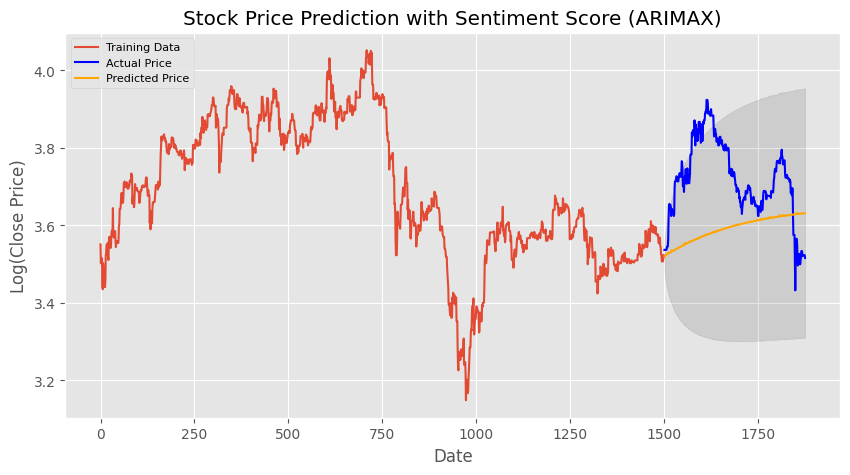

MSE: 46.47898655857636
MAE: 5.728325038485302
RMSE: 6.817549894102452
MAPE: 0.1322179428272677


In [50]:
model_autoARIMAX = auto_arima(train_y,
                              exogenous=train_exog,
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              d=None, test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

print(model_autoARIMAX.summary())

# Lấy thông số order từ auto_arima
p, d, q = model_autoARIMAX.order

# Huấn luyện mô hình ARIMAX
model = ARIMA(train_y, order=(2,0,1), exog=train_exog)
fitted = model.fit()
print(fitted.summary())

# Dự báo trên tập test
forecast_res = fitted.get_forecast(steps=len(test_y), exog=test_exog)
fc = forecast_res.predicted_mean
conf = forecast_res.conf_int(alpha=0.05)

# Series kết quả
fc_series = pd.Series(fc, index=test_y.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_y.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_y.index)

# Vẽ biểu đồ
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_y, label='Training Data')
plt.plot(test_y, color='blue', label='Actual Price')
plt.plot(fc_series, color='orange', label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Stock Price Prediction with Sentiment Score (ARIMAX)')
plt.xlabel('Date')
plt.ylabel('Log(Close Price)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Đánh giá mô hình (chuyển về scale gốc)
actual = np.exp(test_y)
predicted = np.exp(fc)

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(predicted - actual)/np.abs(actual))

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)